# reComBat Tutorial

In this tutorial we investigate the basic functionality of the `reComBat` package and discuss best use cases.
A full documentation is available [here](https://github.com/BorgwardtLab/reComBat#readme).

You can install the `reComBat` via `pip install recombat`.

In this tutorial we are going to use a preprocessed version of the public pseudomonas aeruginosa dataset used in [recent paper](https://doi.org/10.1101/2021.11.22.469488). The preprocessing is described in our paper. If you would like to redo the preprocessing yourself, please follow the steps in `harmonizedDataCreation.py` of [this](https://github.com/BorgwardtLab/batchCorrectionPublicData) repository.

First, we import necessary libraries.

In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as an
from reComBat import reComBat

Define a utility plotting function to make visualisations more convenient

In [2]:
def plot(data,metadata,type='tsne',plot_mode='all',name=None):
    adata = an.AnnData(X=data,obs=metadata)

    if plot_mode == 'all':
        to_colour_by = ['gse',
                        'strain',
                        'MediumCoarse',
                        'GrowthPhase',
                        'Oxygenation',
                        'Temperature_Coarse',
                        'Culture_Coarse',
                        'ZeroHop'
                        ]
    else:
        to_colour_by = [
                        'Zero-hop cluster'
                        ]

    if type == 'tsne':
        sc.tl.tsne(adata,use_rep='X')
        if name is not None:
            sc.pl.tsne(adata,color=to_colour_by,show=False,ncols=1,hspace=0.25,legend_fontsize=8,save='_'+name)
        else:
            sc.pl.tsne(adata,color=to_colour_by,show=True,ncols=1,hspace=0.25,legend_fontsize=8)
    elif type == 'umap':
        sc.pp.neighbors(adata,use_rep='X')
        sc.tl.umap(adata)
        if name is not None:
            sc.pl.umap(adata,color=to_colour_by,show=True,ncols=1,hspace=0.25,legend_fontsize=8,save='_'+name)
        else:
            sc.pl.umap(adata,color=to_colour_by,show=True,ncols=1,hspace=0.25,legend_fontsize=8)
    elif type == 'pca':
        sc.tl.pca(adata,use_highly_variable=False)
        if name is not None:
            sc.pl.pca(adata,color=to_colour_by,show=True,ncols=1,hspace=0.25,legend_fontsize=8,save='_'+name)
        else:
            sc.pl.pca(adata,color=to_colour_by,show=True,ncols=1,hspace=0.25,legend_fontsize=8)

Set the data path. In our case it is the current directory.

In [3]:
data_path = '.'

Load the data. This is a snapshot of the preprocessed dataset used in our publication.

In [4]:
data      = pd.read_csv(os.path.join(data_path,'data_standardized_20211027.csv'),index_col=0)
metadata  = pd.read_csv(os.path.join(data_path,'metadata_allChip_20211027.csv'),index_col=0)

The zero hops are treated as categorical data.

In [5]:
metadata.ZeroHop = metadata.ZeroHop.astype(str)

Use only the coarsed information to obtain more sample overlap

In [6]:
metadata_coarse  = metadata[['gse',
                             'strain',
                             'MediumCoarse',
                             'GrowthPhase',
                             'Oxygenation',
                             'Temperature_Coarse',
                             'Culture_Coarse',
                             'Antibiotic',
                             'ZeroHop']]

Also fill possible `nan` values.

In [7]:
metadata_coarse = metadata_coarse.fillna('None')

Only use samples which are both in the metadata and expression data.
Some expression data might have been filtered out by QC.

In [8]:
valid_ids = list(set(data.index).intersection(set(metadata_coarse.index)))
valid_ids.sort()
data_fit = data.loc[valid_ids]
metadata_fit = metadata_coarse.loc[valid_ids]

Also make sure that the samples are in correct order\
E.g. line 10 of the expression data and metadata correspond to the same sample

In [9]:
assert np.array(data_fit.index == metadata_fit.index).all()

Plot the initial data

... storing 'gse' as categorical
... storing 'strain' as categorical
... storing 'MediumCoarse' as categorical
... storing 'GrowthPhase' as categorical
... storing 'Oxygenation' as categorical
... storing 'Temperature_Coarse' as categorical
... storing 'Culture_Coarse' as categorical
... storing 'Antibiotic' as categorical
... storing 'ZeroHop' as categorical


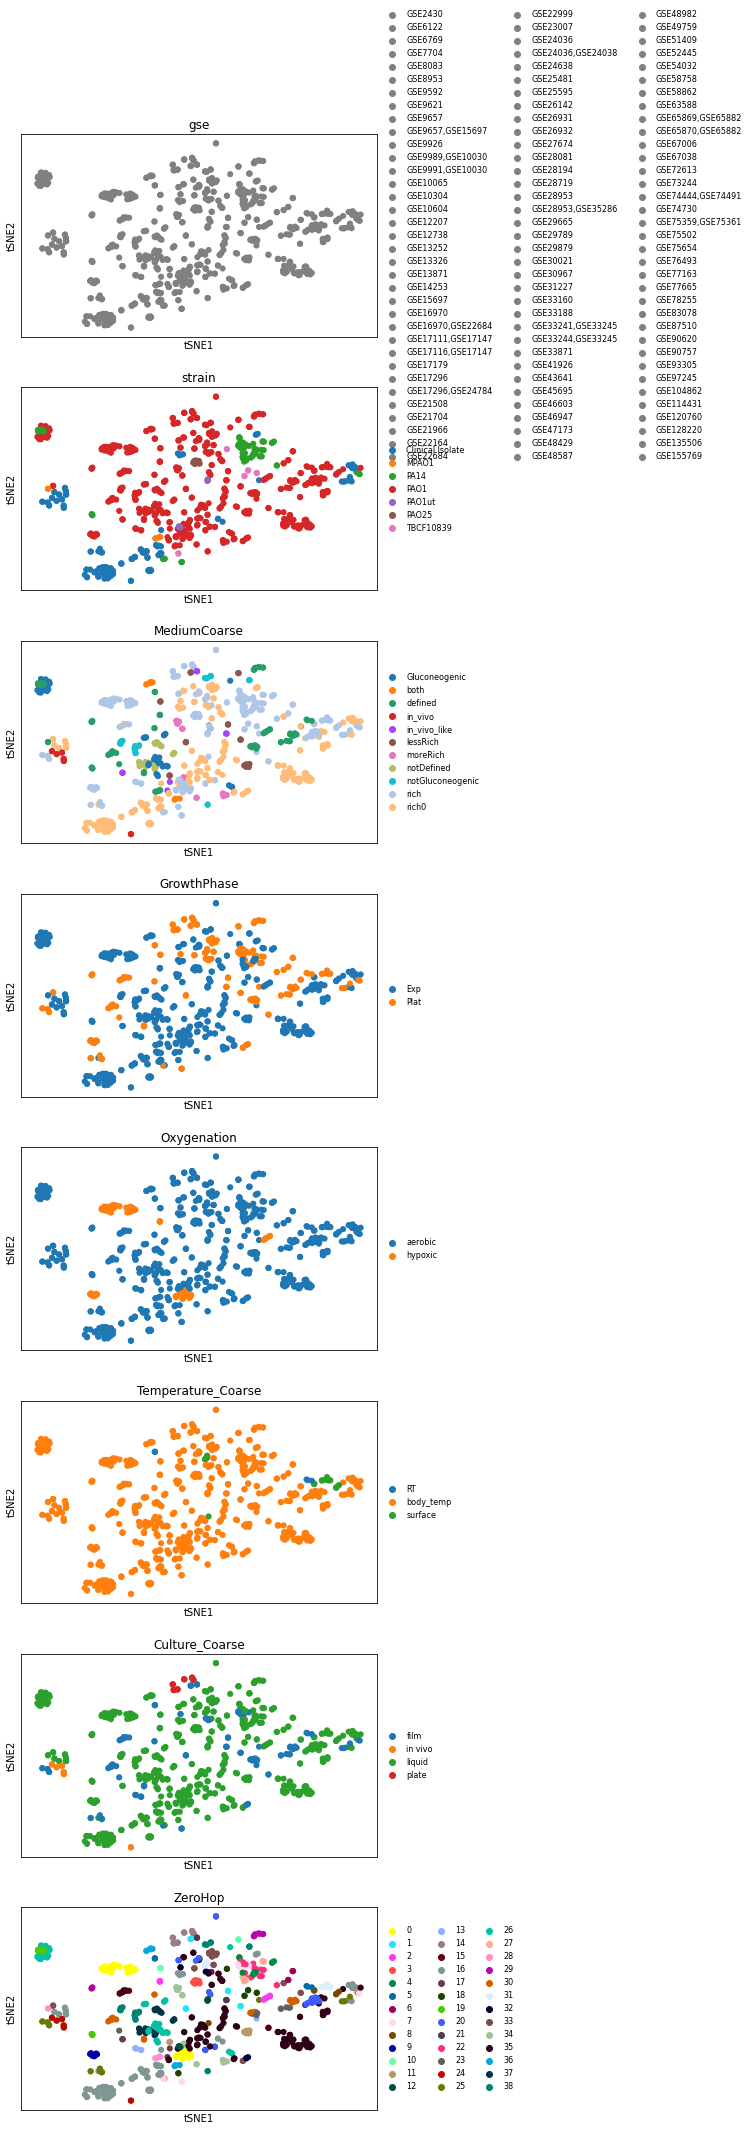

In [10]:
plot(data_fit,metadata_fit,type='tsne')

Initialize the reComBat class

In [11]:
model = reComBat(parametric=True,            # use parametric or non-parametric empirical Bayes method. 
                                             # The parametric method is significantly faster, whereas the 
                                             # non-parametric method is more flexible.
                 model='ridge',              # The regression model to be used. 
                                             # In our experience pure ridge regression performs best for singular design matrices 
                                             # and pure linear regression is best for non=singular matrices.
                 config={'alpha':1e-9},      # Optional arguments for the regression model. 
                                             # We tend to use a tiny regularisation parameter. 
                                             # This has also been cnfirmed by CV.
                 conv_criterion=1e-4,        # The convergence criterion for the empirical Bayes optimisation.
                                             # This value works well in practise.
                 max_iter=1000,              # The maximum number of iterations to stop if convergence is not reached.
                                             # This may also be useful for smaller convergence criteria.
                 n_jobs=1,                   # This parameter is only useful in non-parametric optimisation.
                                             # The non-parametric optimisation is very slow, but can be parallelised easily.
                                             # Set this to the number of CPUs on your machine for significant speed ups.
                 mean_only=False,            # Adjust the mean of your data only (not the variance).
                                             # This can be useful for single sample batches (where the variance is infinite)
                 optimize_params=True,       # If False no empirical Bayes optimisation is performed.
                 reference_batch=None,       # If a reference batch is present (e.g. a batch which is considered "batch effect free")
                                             # it can be set such that all data is adjuste dwith respect to this reference batch.
                 verbose=True                # Turn log messages on or off
                )

Fit reComBat. The input is the raw data, the batch identifiers and the design matrix

In [12]:
model.fit(data_fit,metadata_fit.gse,X=metadata_fit.drop(['gse','ZeroHop'],axis=1))

[reComBat] 2022-08-31 17:05:01,000 Starting to fot reComBat.
[reComBat] 2022-08-31 17:05:01,021 Fit the linear model.
[reComBat] 2022-08-31 17:05:01,241 Starting the empirical parametric optimisation.
[reComBat] 2022-08-31 17:05:01,639 Optimisation finished.
[reComBat] 2022-08-31 17:05:01,640 reComBat is fitted.


Not transform the data. The input stays the same

In [13]:
data_combat = model.transform(data_fit,metadata_fit.gse,X=metadata_fit.drop(['gse','ZeroHop'],axis=1))

[reComBat] 2022-08-31 17:05:01,650 Starting to transform.
[reComBat] 2022-08-31 17:05:01,827 Transform finished.


Plot the output data for comparison

... storing 'gse' as categorical
... storing 'strain' as categorical
... storing 'MediumCoarse' as categorical
... storing 'GrowthPhase' as categorical
... storing 'Oxygenation' as categorical
... storing 'Temperature_Coarse' as categorical
... storing 'Culture_Coarse' as categorical
... storing 'Antibiotic' as categorical
... storing 'ZeroHop' as categorical


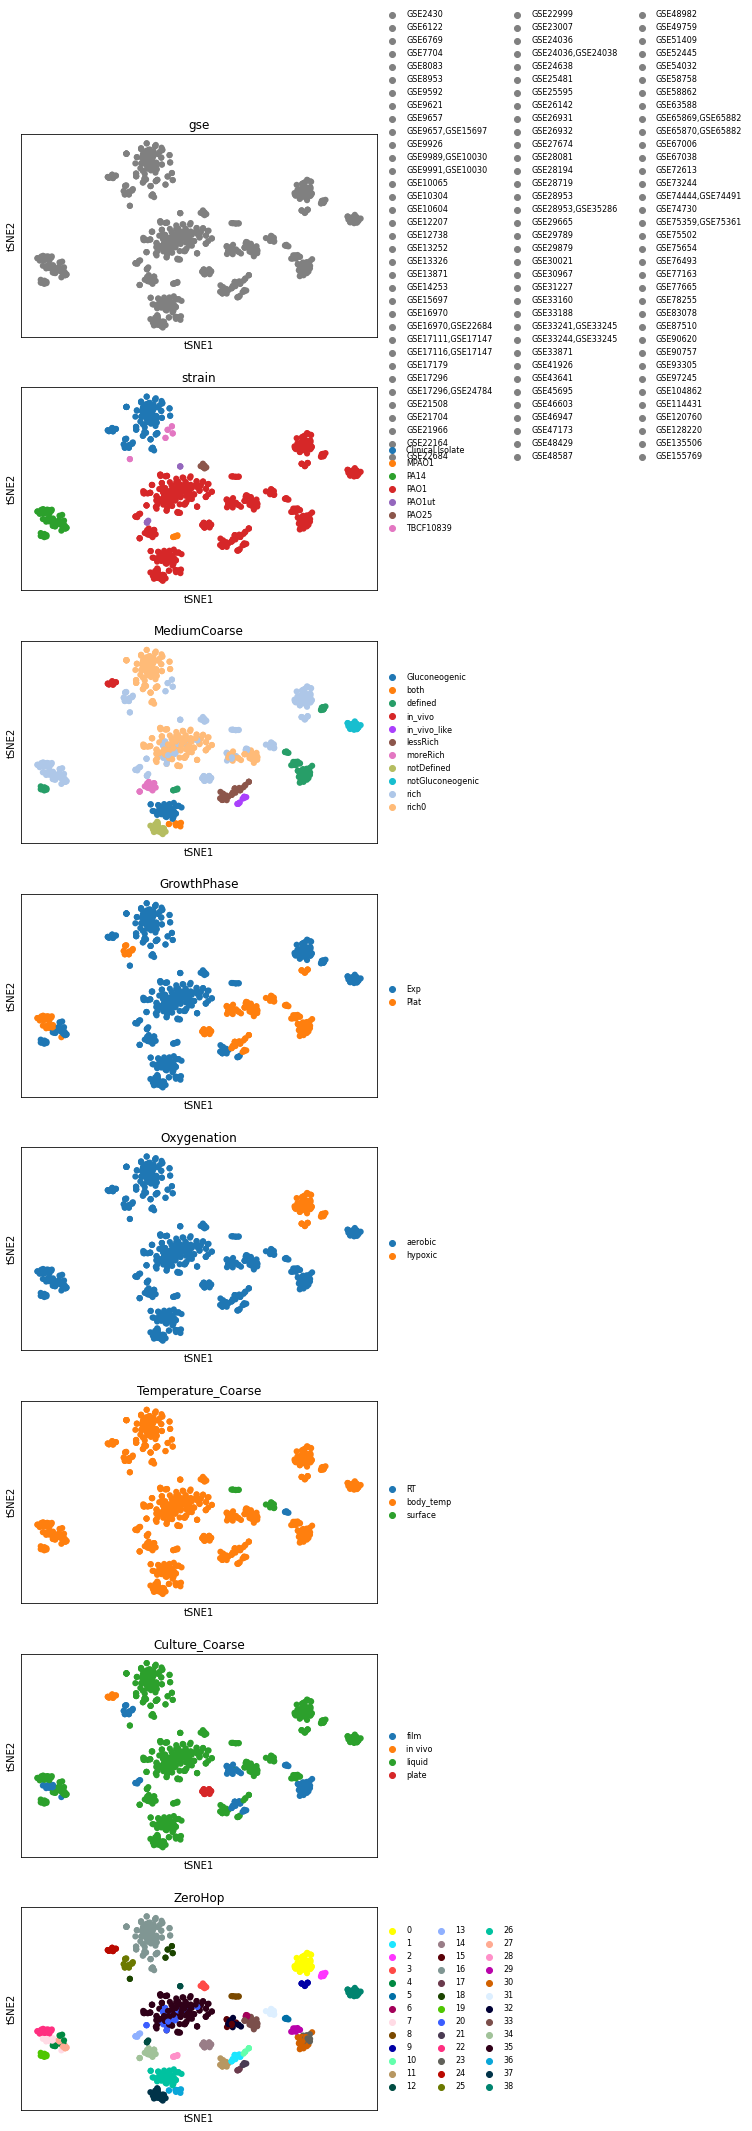

In [14]:
plot(data_combat,metadata_fit,type='tsne')